In [ ]:
from Bio import SeqIO
from tqdm.notebook import tqdm
from collections import defaultdict

from utils.experiment_utils import get_all_experiments_info, load_checkpoint#load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf
from torch.utils.data import DataLoader

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from datasets.virus import ViralDataset

from collections import Counter

In [2]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'virus' in c['name'] 
       and c['config']['training']['save_interval']==1]
cfg = cfg[0]
cfg

{'name': 'virus_0dada5dbfbcb84f4f55774ab3b1babab',
 'dir': 'outputs/virus_0dada5dbfbcb84f4f55774ab3b1babab',
 'config': {'dataset': {'_target_': 'datasets.virus.ViralDataset', 'data_dir': '/orcd/data/omarabu/001/gokul/DistributionEmbeddings/data/spikeprot0430', 'set_size': 16, 'max_length': '${experiment.max_length}', 'esm_name': '${experiment.esm_model_name}', 'progen_name': '${experiment.progen2_model_name}', 'lines_to_read': 100000000, 'tokenize': '${experiment.tokenize}', 'seed': '${seed}'}, 'encoder': {'_target_': 'encoder.protein_encoders.ProteinSetEncoder', 'esm_model_name': '${experiment.esm_model_name}', 'latent_dim': '${experiment.latent_dim}', 'hidden_dim': '${experiment.hidden_dim}', 'pooling': 'mean', 'freeze': False, 'dist_type': 'tx', 'layers': 2, 'heads': 4}, 'model': {'_target_': 'types.NoneType'}, 'generator': {'_target_': 'generator.protein_generator.Progen2Generator', 'progen2_name': '${experiment.progen2_model_name}', 'latent_dim': '${experiment.latent_dim}', 'cond

In [3]:
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_checkpoint(path, 3)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.model.eval()
    enc.to(device)
    gen.model.to(device)
    return enc, gen

def recursive_collate(batch_part):
            if isinstance(batch_part[0], torch.Tensor):
                return torch.stack(batch_part)
            elif isinstance(batch_part[0], dict):
                return {key: recursive_collate([b[key] for b in batch_part]) for key in batch_part[0]}
            else:
                return batch_part  # for strings, lists, or other non-tensor data
            


In [4]:
cfg['config']['dataset']['tokenize'] = False
dataset = hydra.utils.instantiate(cfg['config']['dataset'])
enc, gen = load_model(cfg['config'], cfg['dir'], 'cuda')
# collated = recursive_collate([dataset.__getitem__(i) for i in range(3)])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
dataloader = DataLoader(dataset, batch_size=16)

In [10]:
Zs = []

TLs = []

for i, batch in tqdm(enumerate(dataloader)):
    samples = batch['samples']
    for k, v in samples.items():
        if isinstance(v, torch.Tensor):
            samples[k] = v.to('cuda')

    with torch.no_grad():
        latent = enc(samples)

    Zs.append(latent.cpu().numpy())
    TLs.append(batch['time-loc'])

print(len(Zs))

0it [00:00, ?it/s]

3623


In [22]:
Z = np.vstack(Zs)
T = [item for sub in TLs for item in sub]

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [25]:
pca = PCA(n_components=50, svd_solver='full')
tsne = UMAP(random_state=2121, min_dist=0.5, n_neighbors=50)

pcs = pca.fit_transform(Z)

In [26]:
inds = np.arange(len(Z))
np.random.shuffle(inds)
subsample_inds = inds#[:100000]

In [27]:
tsnes = tsne.fit_transform(pcs[subsample_inds])

/orcd/home/002/gokulg/miniforge3/envs/distemb/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [28]:
T = np.array(T)
months = [t[:7] for t in T[subsample_inds]]
locs = [t.split('-')[-1] for t in T[subsample_inds]]
print(months[:3])
print(locs[:3])

['2020-08', '2023-10', '2021-12']
['Italy', '?', 'USA']


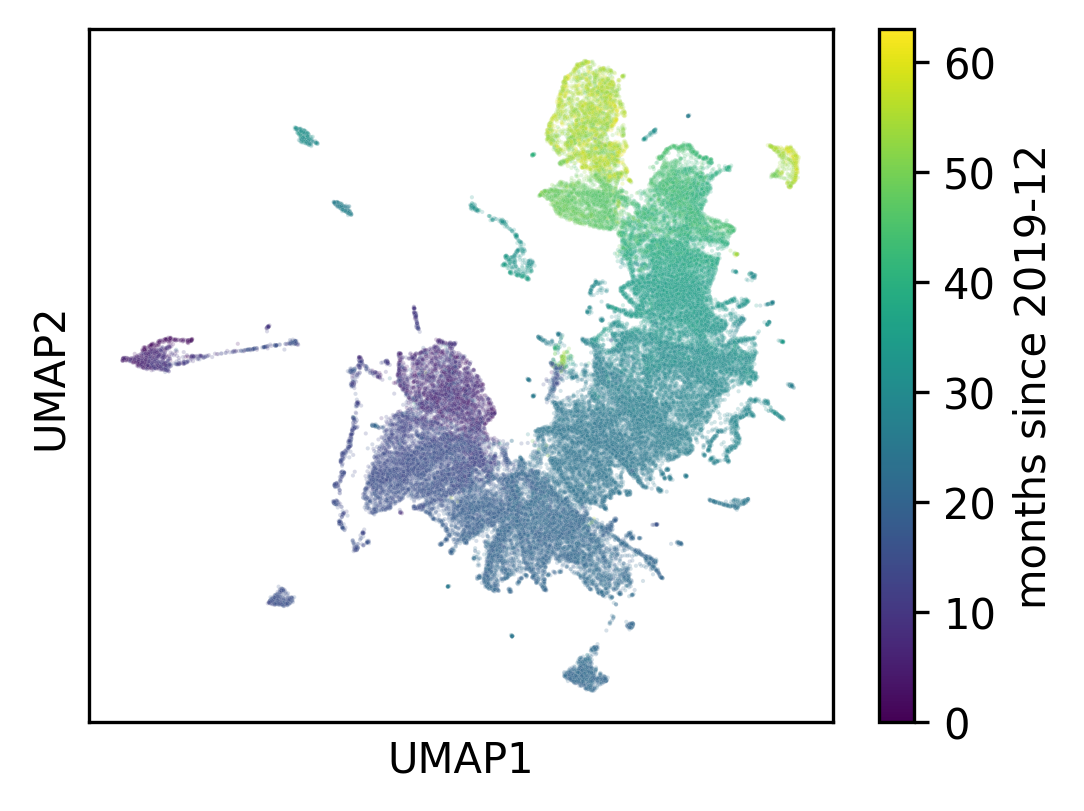

In [29]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from datetime import datetime

# try parsing months safely to datetime
dates = []
for m in months:
    try:
        d = datetime.strptime(m, "%Y-%m")
        dates.append(d)
    except ValueError:
        # skip or use a default? up to you!
        dates.append(None)

# drop None entries (or filter tsnes too if needed!)
valid = [i for i, d in enumerate(dates) if d is not None]
tsnes_valid = tsnes[valid]
dates_valid = [dates[i] for i in valid]

# map to numeric time (e.g. months since min)
min_date = min(dates_valid)
month_nums = np.array([(d.year - min_date.year) * 12 + d.month - min_date.month for d in dates_valid])

# now plot like before!
norm = Normalize(vmin=month_nums.min(), vmax=month_nums.max())
cmap = plt.get_cmap("viridis")

fig, ax = plt.subplots(figsize=(4, 3), dpi=300)

# scatter with explicit ax
sns.scatterplot(x=tsnes_valid[:, 0],
                y=tsnes_valid[:, 1],
                hue=month_nums,
                palette=cmap,
                hue_norm=norm,
                s=1,
                alpha=0.2,
                legend=False,
                ax=ax,)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# make the ScalarMappable manually
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# pass ax to colorbar so it knows where to go :)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("months since 2019-12")

plt.show()



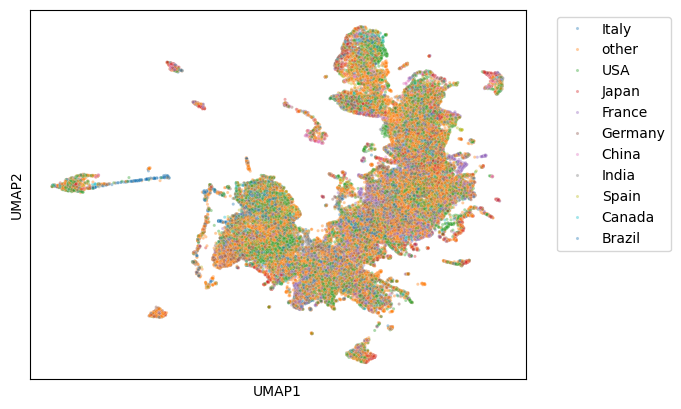

In [50]:
top5 = [c for c, _ in Counter(locs).most_common(11) if c != '?']

# relabel others
grouped_locs = [l if l in top5 else 'other' for l in locs]

sns.scatterplot(x=tsnes[:, 0],
                y=tsnes[:, 1],
                hue=grouped_locs,
                palette='tab10',
                s=5,
                alpha=0.4,
                legend=True)

plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [41]:
Counter(locs)

Counter({'USA': 11915,
         'France': 5457,
         'Germany': 3799,
         'Japan': 2548,
         '?': 2322,
         'Brazil': 2255,
         'Italy': 1909,
         'Spain': 1872,
         'India': 1776,
         'Canada': 1004,
         'China': 974,
         'Mexico': 911,
         'Belgium': 907,
         'Poland': 867,
         'United Kingdom': 841,
         'Indonesia': 776,
         'Austria': 747,
         'Australia': 715,
         'Russia': 712,
         'Switzerland': 709,
         'Portugal': 657,
         'Thailand': 601,
         'Malaysia': 591,
         'South Africa': 583,
         'Norway': 563,
         'Czech Republic': 554,
         'New Zealand': 528,
         'Sweden': 471,
         'Philippines': 456,
         'Croatia': 446,
         'Colombia': 445,
         'Finland': 350,
         'Netherlands': 337,
         'Luxembourg': 336,
         'Lithuania': 306,
         'Ireland': 293,
         'Reunion': 269,
         'Puerto Rico': 241,
         'Roman